<a href="https://colab.research.google.com/github/RevanthBN/COVID-GANs/blob/main/IDL_Baseline_Class_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import *
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import os
from PIL import Image
import torchvision.transforms.functional as TF
import time
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
cuda = torch.cuda.is_available()
cuda
from collections import Counter
! pip install torchsummary
from torchsummary import summary

In [2]:

# ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list
# ! pip install --upgrade --force-reinstall --no-deps kaggle
# # ! kaggle competitions download -c yash612/covidnet-mini-and-gan-enerated-chest-xray
# ! kaggle datasets download -d yash612/covidnet-mini-and-gan-enerated-chest-xray
# ! unzip covidnet-mini-and-gan-enerated-chest-xray.zip -d data

**Apply transformation on the images**

In [3]:
trans_apply=transforms.Compose([transforms.Resize((384,384)),transforms.ToTensor()])

In [4]:
train_dataset=datasets.ImageFolder('/content/drive/MyDrive/data/chest_xray/chest_xray/train',transform=trans_apply)
val_dataset=datasets.ImageFolder('/content/drive/MyDrive/data/chest_xray/chest_xray/val',transform=trans_apply)
test_dataset=datasets.ImageFolder('/content/drive/MyDrive/data/chest_xray/chest_xray/test',transform=trans_apply)

torch.Size([3, 384, 384])
3


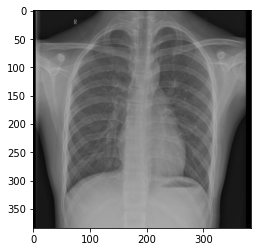

In [5]:
plt.imshow(np.transpose(test_dataset[100][0],axes=(1,2,0)))
print(train_dataset[1600][0].shape)
print(len(train_dataset.classes))
n_classes=len(train_dataset.classes)

In [6]:
print("train",train_dataset.__len__(), len(train_dataset.classes))
print("val",val_dataset.__len__(), len(val_dataset.classes))
print("test",test_dataset.__len__(), len(test_dataset.classes))

train 6862 3
val 27 3
test 635 3


In [7]:
num_workers = 12 if cuda else 0 
    
# Training data
train_loader_args = dict(shuffle=True, batch_size=100, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=800)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=10, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=500)
val_loader = data.DataLoader(val_dataset, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = data.DataLoader(test_dataset, **test_loader_args)


In [8]:
counts=np.zeros(3)
for i in range(3):
  for sample in train_dataset.samples:
    if sample[1]==i:
      counts[i]+=1
print(counts)
weights=torch.FloatTensor(1/counts).cuda()
print(weights)


[ 950. 1821. 4091.]
tensor([0.0011, 0.0005, 0.0002], device='cuda:0')


In [9]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels, momentum=0.9)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels,momentum=0.9))

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64,128,256,512], deepths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        embedding=x
        x = self.decoder(x)
        return x,embedding
      


class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x, embedding = self.decoder(x)
        return x, embedding

In [10]:
def resnet18(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)

def resnet34(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 4, 6, 3], *args, **kwargs)
model18 = resnet18(3, 3)
model34 = resnet34(3,3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(weight=weights)
learningRate = 1e-2
weightDecay = 1e-6
optimizer = torch.optim.SGD(model34.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)
scheduler=optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.6)
model18.to(device)
model34.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=

In [11]:
summary(model18.cuda(), (3, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           9,408
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
         MaxPool2d-4           [-1, 64, 96, 96]               0
        Conv2dAuto-5           [-1, 64, 96, 96]          36,864
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
        Conv2dAuto-8           [-1, 64, 96, 96]          36,864
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
 ResNetBasicBlock-11           [-1, 64, 96, 96]               0
       Conv2dAuto-12           [-1, 64, 96, 96]          36,864
      BatchNorm2d-13           [-1, 64, 96, 96]             128
             ReLU-14           [-1, 64,

In [12]:
summary(model34.cuda(), (3, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           9,408
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
         MaxPool2d-4           [-1, 64, 96, 96]               0
        Conv2dAuto-5           [-1, 64, 96, 96]          36,864
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
        Conv2dAuto-8           [-1, 64, 96, 96]          36,864
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
 ResNetBasicBlock-11           [-1, 64, 96, 96]               0
       Conv2dAuto-12           [-1, 64, 96, 96]          36,864
      BatchNorm2d-13           [-1, 64, 96, 96]             128
             ReLU-14           [-1, 64,

In [13]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.cuda()
    criterion.cuda()
    running_loss = 0.0
    print("Entered Training")
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.cuda()
        target = target.cuda() # all data & model on same device

        outputs,embeddings = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

def test_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        print("Entered Evaluation")
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        model.cuda()
        criterion.cuda()
        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.cuda()
            target = target.cuda()

            outputs,embeddings = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Val Loss: ', running_loss)
        print('Val Accuracy: ', acc, '%')
        return running_loss, acc


In [18]:
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    print("Epoch Number -- ",i+1)
    train_loss = train_epoch(model34, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model34, val_loader, criterion)
    # auc=test_verify(model,ver_loader)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    scheduler.step()
    if (Test_loss[i]<0.3):
      break
    print('='*20)

Epoch Number --  1
Entered Training
Training Loss:  0.0513807014575687 Time:  70.15338206291199 s
Entered Evaluation
Val Loss:  0.6613871802886327
Val Accuracy:  81.48148148148148 %
Epoch Number --  2
Entered Training
Training Loss:  0.052028161379090256 Time:  69.72219848632812 s
Entered Evaluation
Val Loss:  0.3630547523498535
Val Accuracy:  85.18518518518519 %
Epoch Number --  3
Entered Training
Training Loss:  0.05183153002914311 Time:  71.80333209037781 s
Entered Evaluation
Val Loss:  0.3961593310038249
Val Accuracy:  81.48148148148148 %
Epoch Number --  4
Entered Training
Training Loss:  0.05305204381221446 Time:  69.80317807197571 s
Entered Evaluation
Val Loss:  0.39133115609486896
Val Accuracy:  81.48148148148148 %
Epoch Number --  5
Entered Training
Training Loss:  0.05154807020680628 Time:  70.1086220741272 s
Entered Evaluation
Val Loss:  0.4703311075766881
Val Accuracy:  81.48148148148148 %
Epoch Number --  6
Entered Training
Training Loss:  0.052763455398920654 Time:  71.38

In [19]:
def pred(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        print("Entered Evaluation")
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        model.cuda()
        criterion.cuda()
        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.cuda()
            target = target.cuda()

            outputs,embeddings = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [20]:
test_loss, test_acc = pred(model34, test_loader, criterion)

Entered Evaluation
Testing Loss:  0.22469882667064667
Testing Accuracy:  92.5925925925926 %
